In [1]:
! sudo apt update
! sudo apt install tesseract-ocr
! sudo apt install libtesseract-dev

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,346 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,866 kB]
Fetched 6,548 kB in 1s (5,544 

In [2]:
! sudo apt install tesseract-ocr-rus

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-rus is already the newest version (1:4.00~git30-7274cfa-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [3]:
! pip3 install pytesseract

In [4]:
!pip install img2table

In [5]:
# import the necessary packages

import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2
from img2table.ocr import TesseractOCR
from img2table.document import Image
from google.colab import files
from google.colab.patches import cv2_imshow
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from pytesseract import Output
from tabulate import tabulate

In [6]:
uploaded = files.upload()

Saving 141899 .jpg to 141899  (1).jpg


In [7]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [8]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image to be OCR'd")
# ap.add_argument("-o", "--output", required=True,
# 	help="path to output CSV file")
# ap.add_argument("-c", "--min-conf", type=int, default=0,
# 	help="minimum confidence value to filter weak text detection")
# ap.add_argument("-d", "--dist-thresh", type=float, default=25.0,
# 	help="distance threshold cutoff for clustering")
# ap.add_argument("-s", "--min-size", type=int, default=2,
# 	help="minimum cluster size (i.e., # of entries in column)")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values # michael_jordan_stats.png # atevH.jpg
args = {
	"image": "michael_jordan_stats.png",
	"output": "results.csv",
	"min_conf": 0,
	"dist_thresh": 25.0,
	"min_size": 2,
}

In [9]:
# set a seed for our random number generator
np.random.seed(42)

# load the input image and convert it to grayscale
image = cv2.imread("141899 .jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

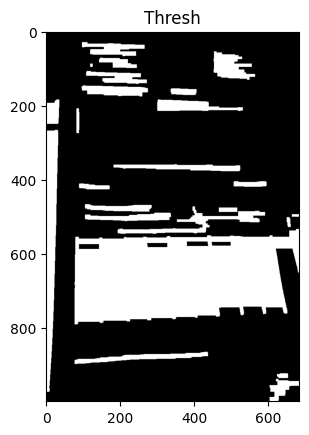

In [10]:
# initialize a rectangular kernel that is ~5x wider than it is tall,
# then smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light
# background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 11))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")

# apply a closing operation using the rectangular kernel to close
# gaps in between characters, apply Otsu's thresholding method, and
# finally a dilation operation to enlarge foreground regions
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)
plt_imshow("Thresh", thresh)

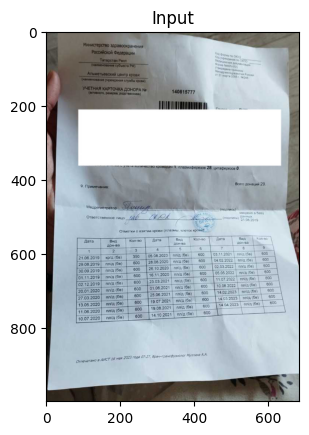

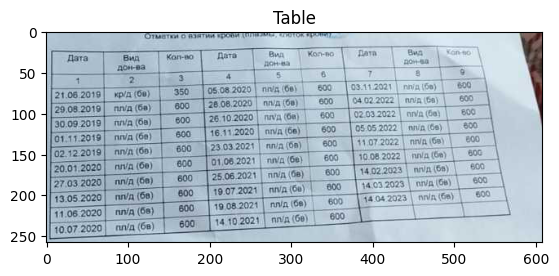

In [11]:
# find contours in the thresholded image and grab the largest one,
# which we will assume is the stats table
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
tableCnt = max(cnts, key=cv2.contourArea)

# compute the bounding box coordinates of the stats table and extract
# the table from the input image
(x, y, w, h) = cv2.boundingRect(tableCnt)
table = image[y:y + h, x:x + w]

# show the original input image and extracted table to our screen
plt_imshow("Input", image)
plt_imshow("Table", table)

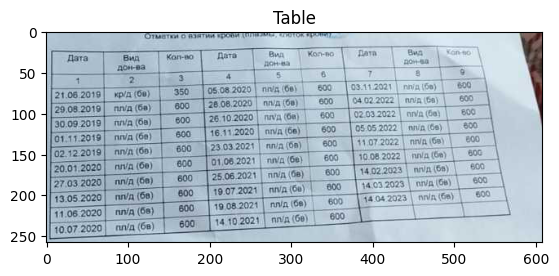

In [13]:
plt_imshow("Table", table)